In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#loading rating dataset
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [ ]:
# loading movie dataset
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#**Advanced** **Techniques**

#GANS

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [ ]:
#normalize ratings for gans
scaler = MinMaxScaler()
ratings['rating'] = scaler.fit_transform(ratings[['rating']])

# data to a tensorFlow dataset
df = tf.data.Dataset.from_tensor_slices((ratings['userId'], ratings['movieId'], ratings['rating']))

# shuffle and batch the dataset
batch_size = 64
df = df.shuffle(buffer_size=1024).batch(batch_size)

# prefetch for performance
df = df.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# create an iterator to convert batches into numpy arrays
iterator = iter(df)

# fetch a batch from the iterator
user_batch, movie_batch, rating_batch = next(iterator)

# tensorFlow tensors to NumPy arrays
user_batch = user_batch.numpy()
movie_batch = movie_batch.numpy()
rating_batch = rating_batch.numpy()


In [ ]:
# define generator
def generator(latent_dim):
    model = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 3),
        nn.Sigmoid()
    )
    return model

In [ ]:
# define discriminator
def discriminator():
    model = nn.Sequential(
        nn.Linear(3, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return model

In [ ]:
# training loop for a gans

def train_gan(generator, discriminator, real_data, latent_dim, epochs, batch_size):
    # define optimizers
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.001)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # define loss function
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        # create real and fake labels
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))


        # train discriminator
        optimizer_d.zero_grad()

        # real data to tensor
        real_data = torch.FloatTensor(real_data)
        d_loss_real = criterion(discriminator(real_data), real_labels)


        # fake data
        z = torch.randn(batch_size, latent_dim)
        # noise to create fake data by generator
        fake_data = generator(z)

        d_loss_fake = criterion(discriminator(fake_data.detach()), fake_labels)

        # total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_d.step()



        # train generator
        optimizer_g.zero_grad()

        g_loss = criterion(discriminator(fake_data), real_labels)
        # gradients for the generator
        g_loss.backward()
        # updates weight
        optimizer_g.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


In [ ]:
 #initialize & train gan to generate fake data based on real data


# define latent dimension for noise input to generator
latent_dim = 1000

# initialize generator and discriminator
gen = generator (latent_dim)
dis = discriminator()

user_movie_ratings = np.column_stack((user_batch, movie_batch, rating_batch))

# train the gan with real data
train_gan(gen, dis, user_movie_ratings, latent_dim=latent_dim, epochs=5000, batch_size=64)


Epoch 0: D Loss: 33.22731018066406, G Loss: 0.6961937546730042
Epoch 1000: D Loss: 8.103785975599465e-10, G Loss: 20.243759155273438
Epoch 2000: D Loss: 9.434722447743127e-11, G Loss: 22.39232063293457
Epoch 3000: D Loss: 3.994088393355355e-11, G Loss: 23.251279830932617
Epoch 4000: D Loss: 2.3861308762196387e-11, G Loss: 23.76618766784668


In [ ]:
#fake data generated by the generator
x = torch.randn(batch_size, latent_dim)
fake_data = gen(x).detach().numpy()

print("Fake Data Generated by the Generator:")
print(fake_data)

Fake Data Generated by the Generator:
[[0.35389587 0.9999976  0.10929426]
 [0.35328117 0.99999976 0.10923776]
 [0.35338527 0.9999995  0.10949679]
 [0.3536296  0.99999845 0.10904401]
 [0.3540845  0.9999987  0.11059201]
 [0.3534806  0.9999989  0.10945074]
 [0.35287195 1.         0.10876599]
 [0.3541294  0.9999919  0.11014752]
 [0.35413784 0.9999994  0.11036736]
 [0.35354424 0.99999857 0.10964604]
 [0.35373318 0.9999932  0.10925864]
 [0.35386232 0.9999962  0.10939768]
 [0.35400102 0.9999993  0.10983086]
 [0.3539141  0.9999968  0.10969862]
 [0.35344583 0.99999857 0.10969495]
 [0.35387516 0.9999989  0.10933194]
 [0.3542884  0.99999654 0.10998067]
 [0.35393795 0.9999987  0.10968037]
 [0.35378382 0.99999666 0.10937633]
 [0.35339317 0.99999964 0.10971252]
 [0.35370103 0.9999982  0.10930659]
 [0.35400718 0.99999845 0.10950377]
 [0.35288778 1.         0.10900559]
 [0.35353965 0.9999993  0.10972776]
 [0.3539331  0.99999714 0.10995132]
 [0.35324636 0.9999999  0.10947213]
 [0.35408005 0.9999987  0.

In [ ]:
#evaluate fake data and real data
fake_userId = fake_data[:, 0]
fake_movieId = fake_data[:, 1]
fake_ratings = fake_data[:, 2]


mean_fake_ratings = np.mean(fake_ratings)
std_fake_ratings = np.std(fake_ratings)


real_ratings = ratings['rating'].values
mean_real_ratings = np.mean(real_ratings)
std_real_ratings = np.std(real_ratings)


print(f"Real Ratings - Mean: {mean_real_ratings}, Std: {std_real_ratings}")
print(f"Fake Ratings - Mean: {mean_fake_ratings}, Std: {std_fake_ratings}")

Real Ratings - Mean: 0.6746149868359228, Std: 0.23712217450702913
Fake Ratings - Mean: 0.10961596667766571, Std: 0.0003802433784585446


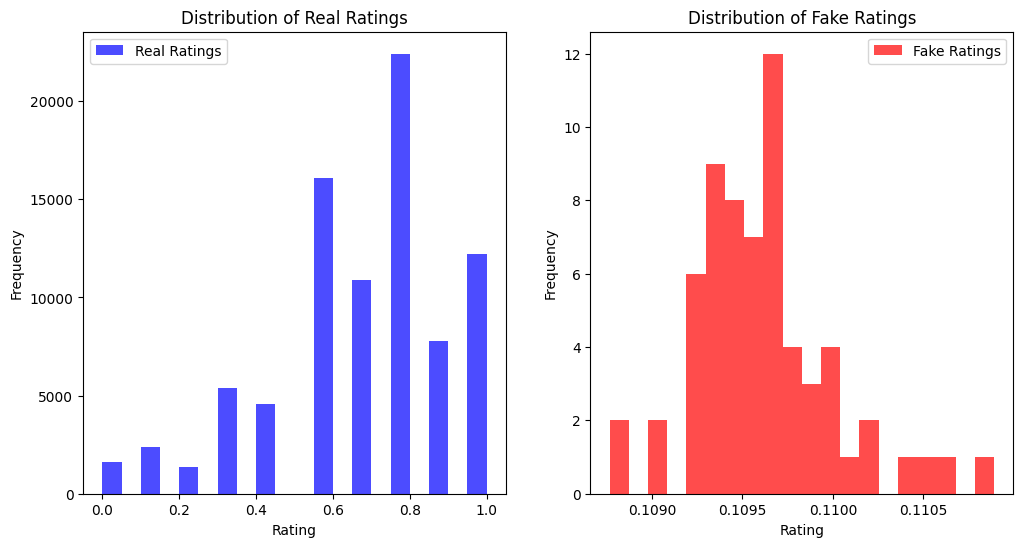

In [ ]:
plt.figure(figsize=(12, 6))

#real
plt.subplot(1, 2, 1)
plt.hist(real_ratings, bins=20, color='blue', alpha=0.7, label='Real Ratings')
plt.title('Distribution of Real Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

#fake
plt.subplot(1, 2, 2)
plt.hist(fake_ratings, bins=20, color='red', alpha=0.7, label='Fake Ratings')
plt.title('Distribution of Fake Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [ ]:
# stopping criteria

#define stopping criteria
def train_gan(generator, latent_dim, epochs=10000, patience=10):
    best_loss = float('inf')
    epochs_without_improvement = 0
    stopping_criteria_met = False

    #train loop
    for epoch in range(epochs):
        # replace simulated loss with actual loss
        loss = torch.randn(1).item()

        # check if loss improved
        if loss < best_loss:
            best_loss = loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # early stopping condition
        if epochs_without_improvement >= patience:
            print(f"Stopping early at epoch {epoch} due to no improvement in loss.")
            stopping_criteria_met = True
            break

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}: Loss = {loss}')

    if not stopping_criteria_met:
        print(f"Training completed for {epochs} epochs.")

latent_dim = 10
generator = generator(latent_dim)

train_gan(generator, latent_dim, epochs=10000, patience=10)


Epoch 0: Loss = -1.0396279096603394
Stopping early at epoch 21 due to no improvement in loss.


In [ ]:
from google.colab import files

df = pd.DataFrame(fake_data, columns=[f'feature_{i}' for i in range(fake_data.shape[1])])

csv_file_name = 'fake_data.csv'
df.to_csv(csv_file_name, index=False)

files.download(csv_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

disc_model = discriminator()


disc_model.eval()

fake_data_tensor = torch.from_numpy(fake_data).float()

predictions = disc_model(fake_data_tensor)

print("Discriminator Predictions on Fake Data:")
print(predictions.detach().numpy())

df_predictions = pd.DataFrame(predictions.detach().numpy(), columns=["Discriminator Output"])
df_predictions.to_csv('discriminator_predictions.csv', index=False)

files.download('discriminator_predictions.csv')


Discriminator Predictions on Fake Data:
[[0.5091148 ]
 [0.5091114 ]
 [0.50911057]
 [0.50911456]
 [0.5091083 ]
 [0.50911146]
 [0.50911146]
 [0.5091116 ]
 [0.50911045]
 [0.50911075]
 [0.509114  ]
 [0.509114  ]
 [0.50911254]
 [0.5091127 ]
 [0.5091099 ]
 [0.5091145 ]
 [0.50911343]
 [0.50911295]
 [0.50911367]
 [0.5091095 ]
 [0.50911355]
 [0.5091144 ]
 [0.5091103 ]
 [0.5091103 ]
 [0.50911146]
 [0.5091099 ]
 [0.5091147 ]
 [0.5091141 ]
 [0.50909925]
 [0.509115  ]
 [0.50911385]
 [0.5091129 ]
 [0.50911045]
 [0.5091135 ]
 [0.50911194]
 [0.50911313]
 [0.509112  ]
 [0.5091128 ]
 [0.50911105]
 [0.5091119 ]
 [0.5091085 ]
 [0.50911355]
 [0.50911164]
 [0.5091099 ]
 [0.50911486]
 [0.5091133 ]
 [0.5091095 ]
 [0.5091147 ]
 [0.5091138 ]
 [0.50911343]
 [0.5091136 ]
 [0.50911266]
 [0.5091117 ]
 [0.50911397]
 [0.5091111 ]
 [0.5091119 ]
 [0.50911355]
 [0.5091114 ]
 [0.50911194]
 [0.5091126 ]
 [0.5091166 ]
 [0.50911087]
 [0.5091113 ]
 [0.50911075]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>